In [1]:
%matplotlib widget
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid
import warpfield
from IPython.display import JSON
import pandas as pd
from widgets import get_mask_widget, ortho_views_widget, play_video_widget

/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
pn_bg = r"~/hpc-rw/lfm/bg"
for file in sorted(pathlib.Path(os.path.expanduser(pn_bg)).iterdir()):
    if file.is_file() and ".npy" in str(file):
        print(file.name)

20250602_1749_LB_bg_100s.npy
20250602_1749_LB_bg_100s_100laser_2fps.npy
20250602_1753_LB_bg_200s.npy
20250602_1753_LB_bg_200s_100laser_2fps.npy
20250610_1904_80laser_5fps.npy
20250610_1904_LB_30k_wo_coverslip_1_bg.npy
20250611_1508_LB_40fps_100laser_bg.npy
20250611_1508_LB_80fps_100laser_bg.npy
20250701_1649_LB_bg_80fps.npy
20250701_1651_LB_bg_40fps.npy
20250701_1654_LB_bg_2fps.npy
20250729_1146_LB_DC1_5dpf_backfill_1_bg.npy
20250729_1200_LB_DC1_5dpf_backfill_bg_wap_40fps.npy
20250729_1233_LB_DC4_5dpf_backfill_bg_2fps.npy
20250729_1600_LB_DC8_5dpf_backfill_bg_2fps.npy
20250729_1605_LB_DC8_5dpf_backfill_bg_2.npy
20250730_1553_LB_25x_5fps_bg.npy
20250731_1654_LB_redFB_25x_2_bg.npy
20250813_1721_psf_2fps_bg.npy
20250813_1729_psf_4fps_bg.npy
20250813_1730_psf_3fps_bg.npy
20250814_1645_LB_80fps_bg.npy
20250814_1646_LB_40fps_bg.npy
20250815_1937_LBKK_backfill_25x_zf5499i_1_10fps_bg.npy
20250815_1938_LBKK_backfill_25x_zf5499i_1_20fps_bg.npy
20250815_1938_LBKK_backfill_25x_zf5499i_1_40fps_bg.n

In [3]:
pn_out = r"~/hpc-rw/lfm/results"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_out, '*'))), reverse=True) if os.path.exists(os.path.join(pn_out, rec, 'deconvolved.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250818_2252_LB_zf552_25x_f5_audiostim_75fps_2
20250818_2247_LB_zf552_25x_f5_audiostim_75fps_1
20250818_2159_LB_zf552_25x_f3_audiostim_40fps_1
20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1
20250815_1933_LBKK_backfill_25x_zf5499i_1_40fps
20250815_1931_LBKK_backfill_25x_zf5499i_1_20fps
20250814_1527_LB_zf552_25x_f5_80fps_2
20250814_1505_LB_zf552_25x_f4_80fps_1
20250729_1557_LB_DC8_5dpf_backfill_1_2fps
20250701_1605_LB_ZF_v552_f6_40fps_1
20250701_1541_LB_ZF_v552_f5_40fps_2
20250701_1538_LB_ZF_v552_f5_40fps_1
20250701_1522_LB_ZF_v552_f4_80fps_1
20250701_1501_LB_ZF_v552_f3_40fps_2
20250701_1438_LB_ZF_v552_f2_40fps_2
20250701_1358_LB_ZF_v552_f1_40fps_2
20250514_1635_LF_ZF552_f4_1_comp_40fps
20250514_1515_LF_ZF552_f1_4_uncomp_40fps
20250513_1351_LB_redFB_1-1k_3d_with_movement


In [4]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"


# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1358_LB_ZF_v552_f1_40fps_2/registered.h5" 
# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1501_LB_ZF_v552_f3_40fps_2/registered.h5"
# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1538_LB_ZF_v552_f5_40fps_1/registered.h5"

dataset_name = "20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1"
psf_name = "20250819_1203_PSF_LB_25x_5fps"
bg_name = "20250814_1646_LB_40fps_bg.npy"
# bg_name = "20250701_1649_LB_bg_80fps.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

### Generate reference volume from recording

In [5]:
if os.path.exists(paths.reg_recipe):
    recipe=lazyh5(paths.reg_recipe)
    crop = recipe["crop"]
    print(crop[1]-crop[0],crop[3]-crop[2],crop)
else:
    recipe = warpfield.Recipe.from_yaml('default.yml')

(115, 910, 360)


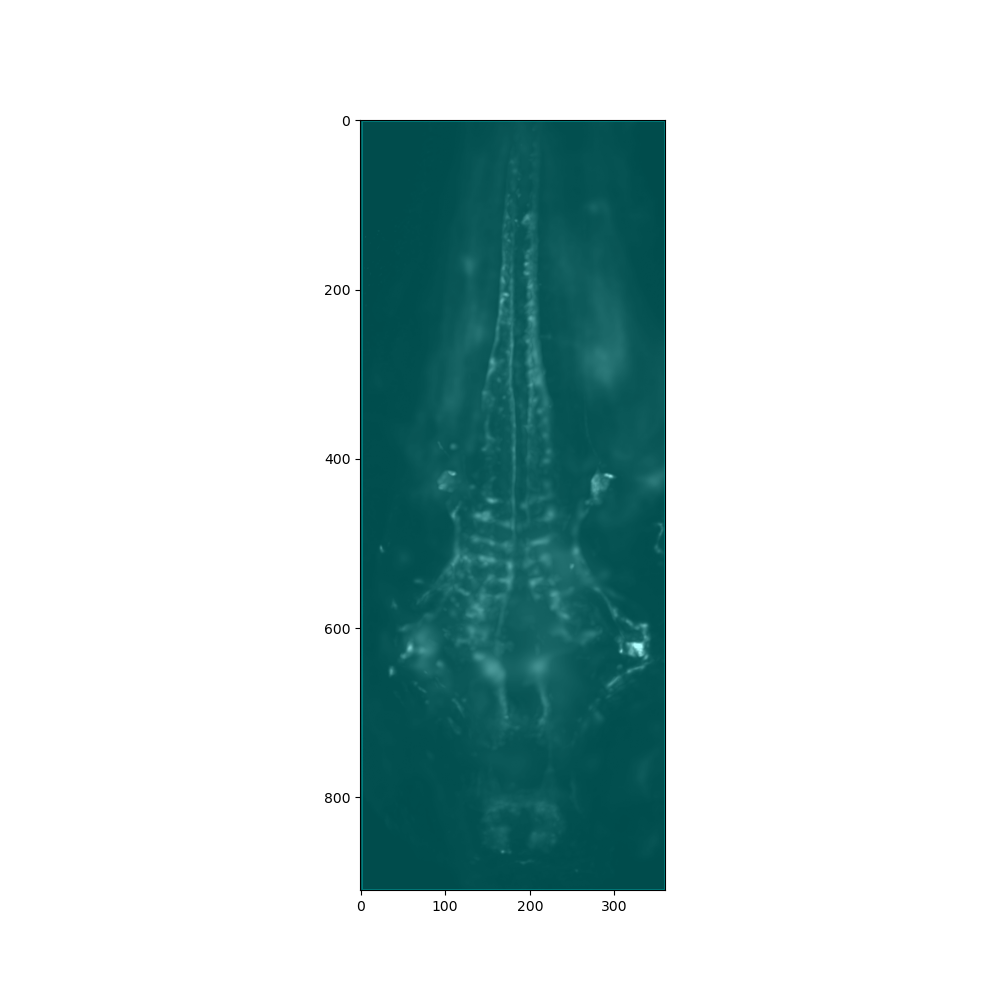

In [6]:
if os.path.exists(paths.reg_recipe):
    print("test")
    with h5py.File(paths.reg_recipe, "r") as f:
        crop = f["crop"]
        print(crop[1]-crop[0],crop[3]-crop[2],crop)
        (y1, y2, x1, x2) = crop
else:
    with h5py.File(paths.deconvolved, "r") as f:
        im = np.array(f["data"][0])
        print(im.shape)
    x1, y1 = 350, 40
    x1, y1 = 0, 0
    x2, y2 = 610, 830
    x2, y2 = im.shape[2], im.shape[1]
    crop = (y1, y2, x1, x2)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(im.max(axis=0), cmap = "gray", vmax=5)
rect = plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="cyan", facecolor="cyan", alpha=0.3
    )
ax.add_patch(rect)


In [7]:
import register
importlib.reload(register)
from register import average_volumes
#inspect theindexes to use for generating the refenrence - should be very little movement
ref_idx = [1000,1020,1]
ref_vol_unreg, video_fn = average_volumes(paths,
                                           ref_idx,
                                           preprocess = lambda x: x[:,crop[0]:crop[1],crop[2]:crop[3]],
                                           vmax=5,
                                           vmin=0,
                                           fps=1,
                                           absolute_limits=True, transpose=True)

play_video_widget(video_fn)

Averaging:   0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
ortho_views_widget(ref_vol_unreg.transpose(0,2,1), vmin = 0, vmax=3, absolute_limits=True)

OrthoViewsWidget(coords=[56, 176, 448], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

In [20]:
importlib.reload(warpfield)

#refine reference volume by registering every volume to the average and then averaging again
def register_reference(vol):
    return warpfield.register_volumes(ref_vol_unreg, vol[:,crop[0]:crop[1],crop[2]:crop[3]], recipe)[0]
    


ref_vol, video_fn = average_volumes(paths,
                                      ref_idx,
                                     preprocess = register_reference,
                                      vmax=100,
                                      vmin=0,
                                      absolute_limits=False,
                                     transpose = False,
                                    fps=1
                                      )

showvid(video_fn)

Averaging:   0%|          | 0/20 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
ortho_views_widget(ref_vol.transpose(0,2,1), vmin = 0, vmax=3, absolute_limits=True)

OrthoViewsWidget(coords=[56, 176, 448], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

In [16]:
import widgets
importlib.reload(widgets)
from widgets import ortho_views_widget, get_mask_widget
get_mask_widget(ref_vol, paths.reg_mask, vmin=0, vmax=3, figsize=(16,5), mask_every=7, sigma=5.0, transpose=True)

In [23]:
with h5py.File(paths.reg_mask, "r") as f:
    mask_3d = np.array(f["mask_3d"])
    
ortho_views_widget(mask_3d*ref_vol, vmax = 1, absolute_limits=True, transpose=True)

OrthoViewsWidget(coords=[56, 176, 448], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

### Test mini registration

In [43]:
recipe = warpfield.Recipe.from_yaml('default.yml')
print(recipe.pre_filter)
# print("\n")
for i in range(4):
    print(recipe.levels[i])
    # print("\n")
    

clip_thresh=0.0 dog=True low=0.5 high=10.0 soft_edge=0.0
block_size=[-1, -1, -1] block_stride=1.0 project=Projector(max=True, normalize=False, dog=True, low=0.5, high=10.0, periodic_smooth=False) tukey_ref=0.5 smooth=Smoother(sigmas=[1.0, 1.0, 1.0], shear=None, long_range_ratio=0.05) affine=False median_filter=True update_rate=1.0 repeats=1
block_size=[-2, -2, -2] block_stride=0.5 project=Projector(max=True, normalize=False, dog=True, low=2.0, high=10.0, periodic_smooth=False) tukey_ref=0.5 smooth=Smoother(sigmas=[0.5, 0.5, 0.5], shear=None, long_range_ratio=0.05) affine=True median_filter=False update_rate=1.0 repeats=10
block_size=[64, 64, 64] block_stride=1.0 project=Projector(max=True, normalize=False, dog=True, low=2.0, high=10.0, periodic_smooth=False) tukey_ref=0.5 smooth=Smoother(sigmas=[2.0, 2.0, 2.0], shear=None, long_range_ratio=0.1) affine=False median_filter=True update_rate=1.0 repeats=5
block_size=[32, 32, 32] block_stride=0.5 project=Projector(max=True, normalize=False,

In [41]:
#generate default registration recipe
# create a basic recipe:
recipe = warpfield.Recipe()
recipe.pre_filter.clip_thresh = 0  # clip DC background, if present

# translation level properties
recipe.levels[0].project.max = True
recipe.levels[0].repeats = 1

# affine level properties
recipe.levels[-1].block_stride = 0.5
recipe.levels[-1].project.max = True
recipe.levels[-1].repeats = 10

# add non-rigid registration levels:
recipe.add_level(block_size=[64, 128, 128])
recipe.levels[-1].smooth.sigmas = [1.0, 1.0, 1.0]
recipe.levels[-1].repeats = 10

recipe.add_level(block_size=[64, 64, 64])
recipe.levels[-1].block_stride = 0.5
recipe.levels[-1].smooth.sigmas = [1.0, 1.0, 1.0]
recipe.levels[-1].repeats = 15

recipe.add_level(block_size=[32, 32, 32])
recipe.levels[-1].block_stride = 0.5
recipe.levels[-1].smooth.sigmas = [2.0, 2.0, 2.0]
recipe.levels[-1].repeats = 15


print("my recipe:")
print(recipe.pre_filter)

for i in range(5):
    
    print(recipe.levels[i])

    

my recipe:
clip_thresh=0 dog=True low=0.5 high=10.0 soft_edge=0.0
block_size=[-1, -1, -1] block_stride=1.0 project=Projector(max=True, normalize=False, dog=True, low=0.5, high=10.0, periodic_smooth=False) tukey_ref=0.5 smooth=Smoother(sigmas=[1.0, 1.0, 1.0], shear=None, long_range_ratio=0.05) affine=False median_filter=True update_rate=1.0 repeats=1
block_size=[-2, -2, -2] block_stride=0.5 project=Projector(max=True, normalize=False, dog=True, low=0.5, high=10.0, periodic_smooth=False) tukey_ref=0.5 smooth=Smoother(sigmas=[0.5, 0.5, 0.5], shear=None, long_range_ratio=0.05) affine=True median_filter=False update_rate=1.0 repeats=10
block_size=[64, 128, 128] block_stride=1.0 project=Projector(max=True, normalize=False, dog=True, low=0.5, high=10.0, periodic_smooth=False) tukey_ref=0.5 smooth=Smoother(sigmas=[1.0, 1.0, 1.0], shear=None, long_range_ratio=0.05) affine=False median_filter=True update_rate=1.0 repeats=10
block_size=[64, 64, 64] block_stride=0.5 project=Projector(max=True, nor

In [49]:
import register, i_o
importlib.reload(register)
from register import mini_registration
test_reg_frames = [1750, 2150, 2]
fn_addendum = "standard"
video_fn, video_reg_fn, warpfields, metrics = mini_registration(paths, 
                                          test_reg_frames,
                                          ref_vol.transpose((0,2,1)),
                                          recipe,
                                         fn_addendum = fn_addendum,
                                          preprocess = lambda x: x[:,crop[0]:crop[1],crop[2]:crop[3]].transpose((0,2,1)),
                                          vmax=3,
                                          vmin=0,
                                          absolute_limits=True,
                                          fps=10,)


dict_keys(['r', 'mse', 'ssim', 'dmf'])


Mini registration:   0%|          | 0/200 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
print(video_reg_fn)
play_video_widget(video_reg_fn)

/home/lubo12/hpc-rw/lfm/results/20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1/mini_registration_registered_standard_f[1750, 2150, 2]_vmin0_vmax3_al.mp4


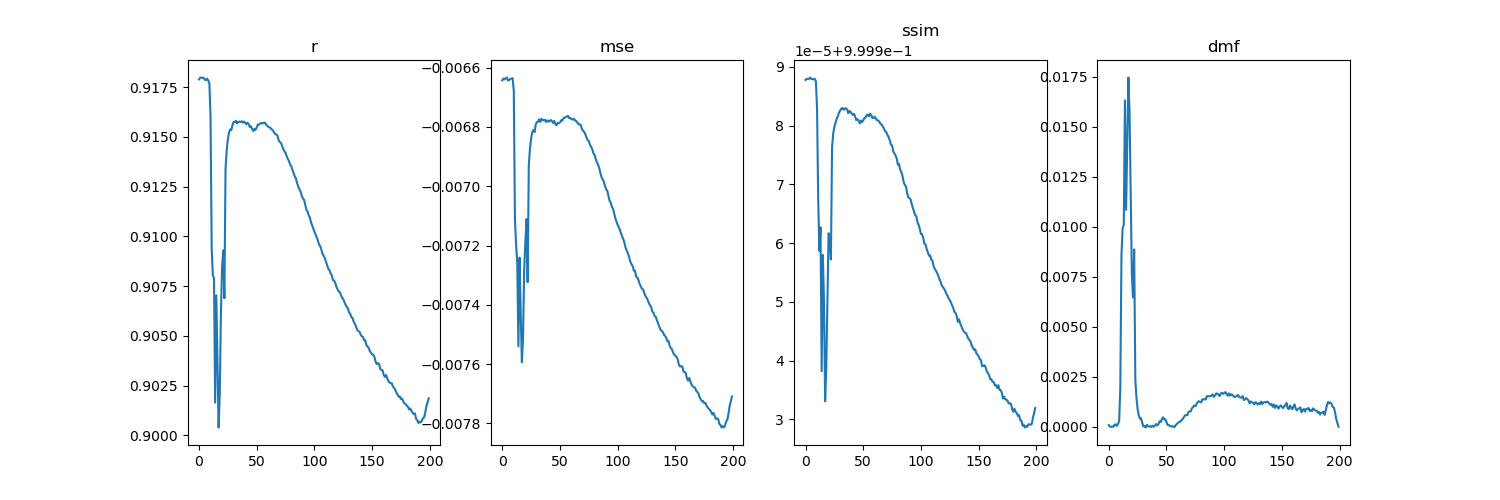

In [52]:
fig, ax = plt.subplots(1,4,figsize=(15,5))
ax[0].plot(metrics["r"])
ax[0].set_title("r")
ax[1].plot(metrics["mse"])
ax[1].set_title("mse")
ax[2].plot(metrics["ssim"])
ax[2].set_title("ssim")
ax[3].plot(metrics["dmf"])
ax[3].set_title("dmf")
plt.savefig(os.path.join(paths.pn_outrec,f"mini_registration_registered_{fn_addendum}_f{test_reg_frames}_metrics.png"))

In [24]:
fn_vid = paths.deconvolved[:-3] + f"{"_dff" if 1 else ""}_mip_vmin{1}_vmax{1}{"_al" if 1 else ""}.mp4"

### register the whole recording

In [56]:
#locally
import register
importlib.reload(register)
from register import save_register_recipe, register_recording, registered_volume_reader
save_register_recipe(paths, 
                     recipe=recipe,
                     ref_vol=ref_vol,
                     crop = crop,
                     r_threshold=0.91,
                     cov_tau=100,
                     eye_mask = None,
                     vid_params = {"write_video": True,
                                   "write_dff_video": True,
                                   "fps": 40,
                                   "vid": {"vmax": 3,
                                           "vmin": 0,
                                           "absolute_limits": True},
                                   "dff": {"vmax": 10,
                                           "vmin": -10,
                                           "absolute_limits": True,
                                           "tau": 10,},
                                   "zpos": None,
                                   "scalebar": 200,
                                   "transpose": True},

                    )

Recipe saved to /home/lubo12/hpc-rw/lfm/results/20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1/reg_recipe.yaml


In [73]:
#locally
register_recording(paths)


Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Writing video to /home/lubo12/hpc-rw/lfm/results/20250701_1501_LB_ZF_v552_f3_40fps_2/registered_T_vmin0-vmax20_al.mp4
Writing dff video to /home/lubo12/hpc-rw/lfm/results/20250701_1501_LB_ZF_v552_f3_40fps_2/registered_dff_T_vmin-10-vmax10_al.mp4


Registering:   0%|          | 0/4020 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
#on the cluster 
email = 'lukas.born@charite.de' 
#cmd_prefix = ['ssh', 'lubo12@s-sc-frontend1'] # if outside HPC (add your user name), otherwise: 
cmd_prefix = [] #if inside HPC
from slurm import PythonExecutorSLURM
slex = PythonExecutorSLURM(job_path=paths.pn_outrec, job_name='reg'+paths.dataset_name, conda_env='lfm1',
                                     time="1-00:00:00", partition="gpu", gres="gpu:1", cpus_per_task=16, mem='256G',ntasks=1,nodes=1,exclude="s-sc-pgpu03",
                                     cmd_prefix=cmd_prefix, mail_user=email, mail_type='ALL,TIME_LIMIT_90')

In [58]:
import register
importlib.reload(register)
from register import save_register_recipe, register_recording, registered_volume_reader
job_id = slex.submit(register_recording, paths)
print(paths.dataset_name)

Submitted batch job 6079688

20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1


### Analysis

In [61]:
reg = lazyh5(paths.registered)
reg

<IPython.core.display.JSON object>

In [ ]:
from signal_extraction import segment
result, mip = segment(paths)

In [115]:
from i_o import VolumeReader
from video import AVWriter2

tau = 10
# idx = range(4020)
idx=range(1000,1100)
reader = VolumeReader(paths.registered, "data", i_frames=idx, prefetch = 2)
video_fn = "test.mp4"
# video_fn ="/home/lubo12/hpc-rw/lfm/results/20250701_1538_LB_ZF_v552_f5_40fps_1/registered_df_vmin0_vmax2_al.mp4"
video_writer= AVWriter2(video_fn, fps = 10, expected_indeces=idx)
shape = reader.get_shape("data")
print(shape)

average_vol = cp.ones(shape = shape[1:])
for frame_n, vol in tqdm(reader):
    vol = cp.asarray(vol)+1
    average_vol = (1/tau) * vol+ (1-(1/tau)) * average_vol
    dff_vol = (vol - average_vol)
    dff_mip = create_projection_image(dff_vol,
                                              vmax=2, vmin=0, absolute_limits=True,
                                              zpos=None, scalebar=200, text=f"f{frame_n}",transpose=True)
    video_writer.write(dff_mip, frame_n)
video_writer.close()
display(Video(video_fn, embed=True, width=600, html_attributes="controls loop"))

(4020, 155, 770, 230)


  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
import register, video
importlib.reload(register)
from register import save_register_recipe, register_recording, registered_volume_reader
regreader = registered_volume_reader(paths, idx=np.arange(1,20,1))


0it [00:00, ?it/s]

(1, array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.10795094e-13, 1.30038314e-13, 1.53902390e-13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.36773750e-13, 6.49323585e-13, 7.95040032e-13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [8.84088054e-19, 1.02498648e-18, 1.09389115e-18, ...,
         2.30285854e-15, 2.17291670e-15, 1.25697042e-15],
        [6.72679508e-19, 7.70449257e-19, 9.31001189e-19, ...,
         2.18151324e-15, 2.03737449e-15, 1.17864698e-15],
        [5.44110515e-19, 5.60434717e-19, 5.92385447e-19, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.11975513e-13, 1.34654888e-13, 1.63290591e-13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.81882167e-